In [1]:
from numqt import *
import numpy as np
import matplotlib.pyplot as plt

# ===========================================================
# Setup 
# ===========================================================
L = 1
hbar = 1
m = 1
q = -1
xbounds = (0, L)
dx = 0.001  # Slightly larger dx for faster computation
nx = int(np.abs(xbounds[1] - xbounds[0]) / dx)

#-----------------------------------------------------------
# Mesh and basis setup
#-----------------------------------------------------------
xbounds = (-L, L)
dx       = 0.0001
nx       = int((xbounds[1] - xbounds[0]) / dx)
mesh     = Mesh(dims=1, xbounds=xbounds, nx=nx)
N_states = 20
psi_fn   = lambda n, mesh: iw_state(n, mesh, center=0, L=np.abs(xbounds[1] - xbounds[0]))
basis    = (psi_fn, N_states)

# Get operators
operators = canonic_ops(mesh, basis=basis, ops_to_compute=["p2", "x"], hbar=hbar)
ops = operators.get_ops()
px2 = ops["p2"]
x = ops["x"]

# Static Hamiltonian
H0 = px2 / (2*m)

In [2]:
# ===========================================================
# EXAMPLE 1: Single array parameter (E0_vals)
# ===========================================================
print("=== EXAMPLE 1: Array of E0 values ===")

omega = 0.95 * 3 * hbar * np.pi**2 / (2 * m * L**2)
T = 2 * np.pi / omega
E0_vals = np.linspace(0, - 10 * hbar * omega / (q * L), 300)

time_dep_args = {
    "amplitudes": E0_vals,
    "frequencies": omega,
    "periods": T
}

# Time-dependent Hamiltonian
def H_dip (E0, w, t): 
    return - q * E0 * np.cos(w * t) * x

# Create Hamiltonian with array parameter
H_array_E0 = Hamiltonian(H_time_indep=H0, 
                         H_time_dep=H_dip, 
                         time_dep_args=time_dep_args,  # E0_vals is an array!
                         mesh=mesh,
                         basis=basis,
                         verbose=False)

# This should return shape (len(E0_vals), N_states)
quasi_energies_1D = H_array_E0.solve_quasi_energies(Nt=300, rescale_omega=omega, brillouin_omega=omega)

=== EXAMPLE 1: Array of E0 values ===


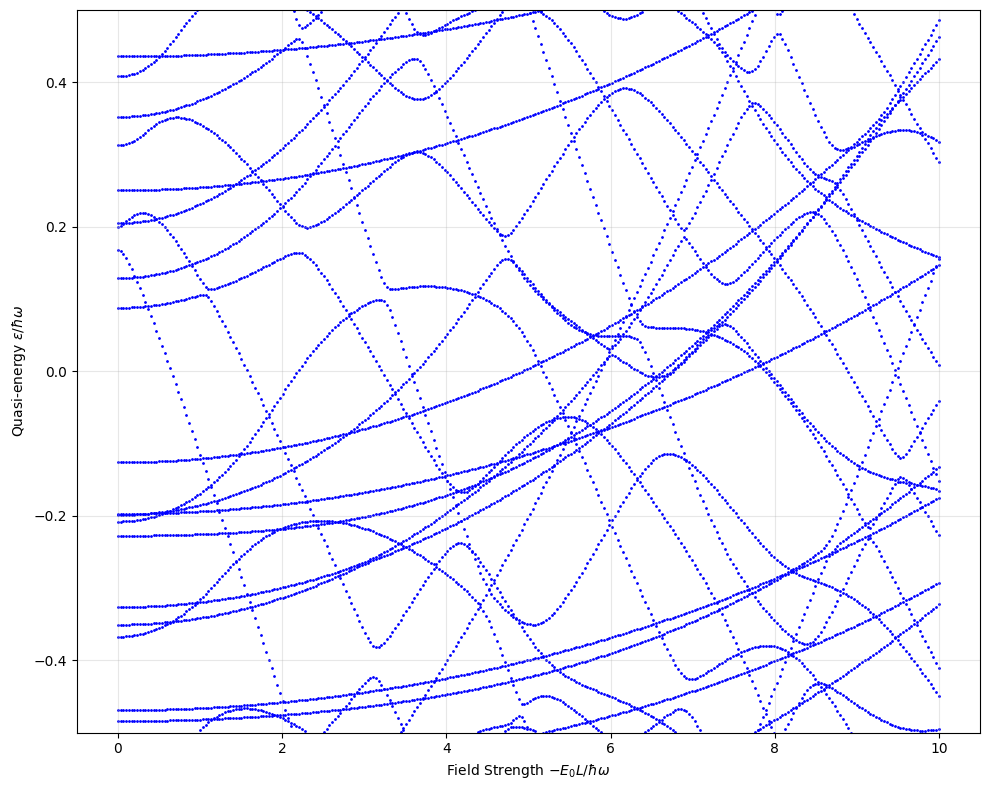

In [3]:
E0_normalized = - E0_vals * q * L / (hbar * omega)

fig, ax = plt.subplots(1,1, figsize=(10, 8))

for n in range(min(20,N_states)):  # Show first 9 levels
    ax.scatter(E0_normalized, quasi_energies_1D[:, n], c = "b", s=1,  alpha=1)

ax.set_xlabel('Field Strength $-E_0 L / \\hbar\\omega$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()

In [4]:
# ===========================================================
# EXAMPLE 2: Two array parameters (E0_vals and omega_vals)
# ===========================================================
print("\n=== EXAMPLE 2: Arrays of E0 and omega values ===")

omega_vals = np.linspace(0.01, 0.95, 3) * 3 * hbar * np.pi**2 / (2 * m * L**2)
T_vals = 2 * np.pi / omega_vals
E0_vals = np.linspace(0, - 10 * hbar * omega_vals[-1] / (q * L), 300)

time_dep_args = {
    "amplitudes": E0_vals,
    "frequencies": omega_vals,
    "periods": T_vals
}

def H_dip_2D(E0, omega, t):
    """Time-dependent Hamiltonian that works with scalar parameters"""
    return - q * E0 * np.cos(omega * t) * x

# Create Hamiltonian with two array parameters
H_array_2D = Hamiltonian(H_time_indep=H0, 
                         H_time_dep=H_dip_2D, 
                         time_dep_args=time_dep_args,
                         mesh=mesh,
                         basis=basis,
                         verbose=False)

# This should return shape (len(E0_vals), len(omega_vals), N_states)
quasi_energies_2D = H_array_2D.solve_quasi_energies(Nt=200)


=== EXAMPLE 2: Arrays of E0 and omega values ===


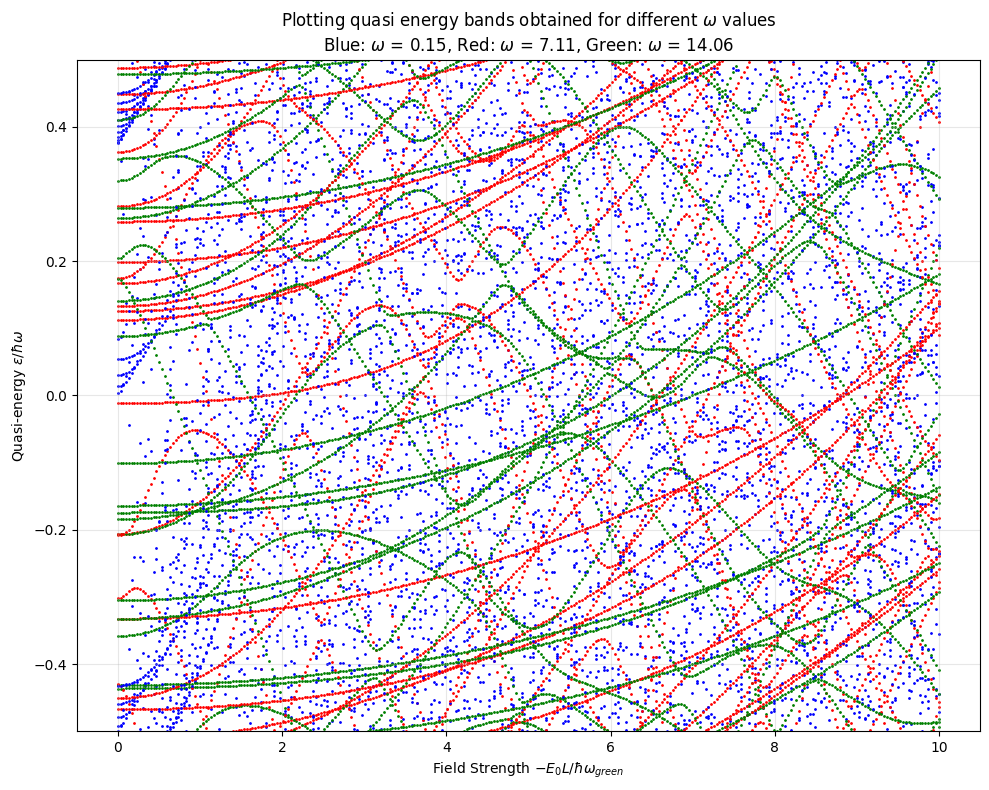

In [5]:
colors = ["b", "r", "g"]
E0_normalized = - E0_vals * q * L / (hbar * omega_vals[-1])

fig, ax = plt.subplots(1,1, figsize=(10, 8))

for n in range(min(20,N_states)):  # Show first 9 levels
    for w in range(len(omega_vals)):
        ax.scatter(E0_normalized, quasi_energies_2D[:, w, n], c = colors[w], s=1,  alpha=1)

ax.set_xlabel('Field Strength $-E_0 L / \\hbar\\omega_{green}$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 0.5)
ax.set_title(r"Plotting quasi energy bands obtained for different $\omega$ values" + "\n"+ f"Blue: $\\omega$ = {omega_vals[0]:.2f}, Red: $\\omega$ = {omega_vals[1]:.2f}, Green: $\\omega$ = {omega_vals[2]:.2f}")

plt.tight_layout()
plt.show()

In [6]:
# ===========================================================
# EXAMPLE 3: Mixed scalar and array parameters
# ===========================================================
print("\n=== EXAMPLE 3: Mixed scalar and array parameters ===")

omega_vals = np.linspace(1, 10, 300)  # Array
E0_vals = - 1 * hbar * omega_vals[-1] / (q * L) # Scalar
T_vals = 2 * np.pi / omega_vals

time_dep_args = {
    "amplitudes": E0_vals,
    "frequencies": omega_vals,
    "periods": T_vals
}

def H_mixed(E0, omega, t):
    """Hamiltonian with mixed parameters"""
    return - q * E0 * np.cos(omega * t) * x

H_mixed_params = Hamiltonian(H_time_indep=H0, 
                             H_time_dep=H_mixed, 
                             time_dep_args=time_dep_args,
                             mesh=mesh,
                             basis=basis,
                             verbose=False)

# This should return shape (len(omega_mixed), N_states)
quasi_energies_mixed = H_mixed_params.solve_quasi_energies(Nt=200, brillouin_omega=1.0)


=== EXAMPLE 3: Mixed scalar and array parameters ===


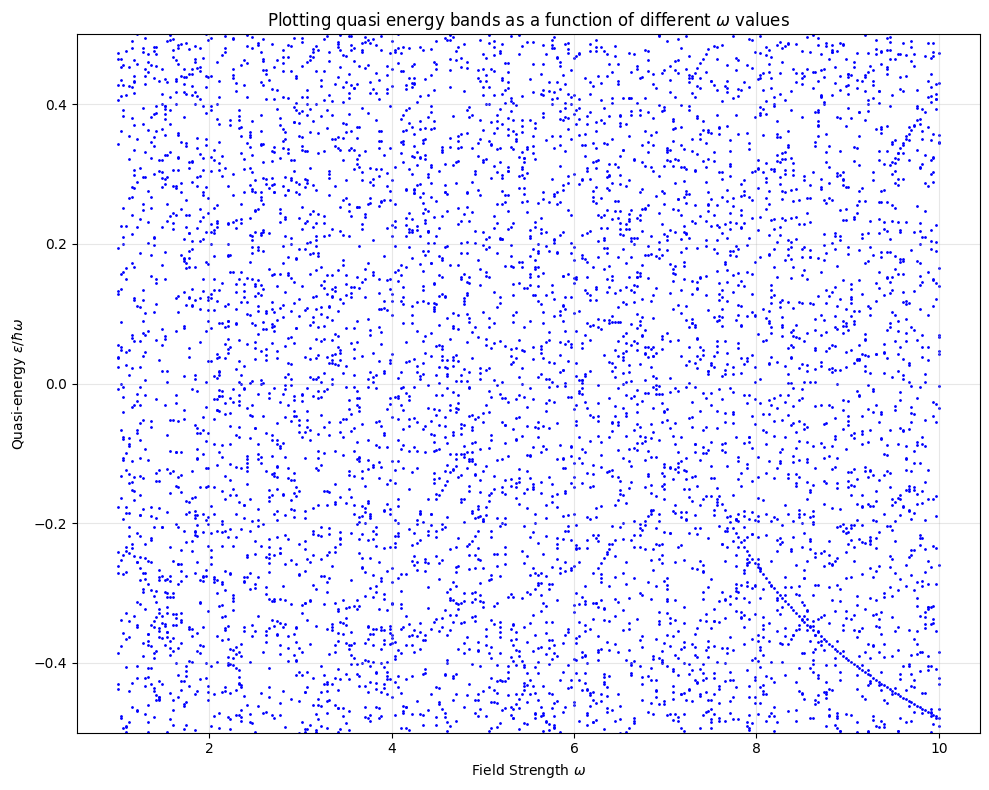

In [7]:
colors = ["b", "r", "g"]
E0_normalized = - E0_vals * q * L / (hbar * omega)

fig, ax = plt.subplots(1,1, figsize=(10, 8))

for n in range(min(20,N_states)):  # Show first 9 levels
    ax.scatter(omega_vals, quasi_energies_mixed[:, n], c = "b", s=1,  alpha=1)

ax.set_xlabel('Field Strength $\\omega$')
ax.set_ylabel('Quasi-energy $\\epsilon / \\hbar\\omega$')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.5, 0.5)
ax.set_title(r"Plotting quasi energy bands as a function of different $\omega$ values")

plt.tight_layout()
plt.show()